<a href="https://colab.research.google.com/github/Alafiade/ConV-Models/blob/main/DENSENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.backends.cudnn import deterministic
import torchvision
from torchvision import datasets, models, transforms # Added missing import statement
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np

In [2]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
100% 194M/195M [00:01<00:00, 127MB/s] 
100% 195M/195M [00:01<00:00, 102MB/s]


In [3]:
!unzip breast.zip

Archive:  breast.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/be

In [4]:
!pip install split-folders
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directories
data_dir = "/content/Dataset_BUSI_with_GT"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Copying files: 1578 files [00:01, 1208.54 files/s]


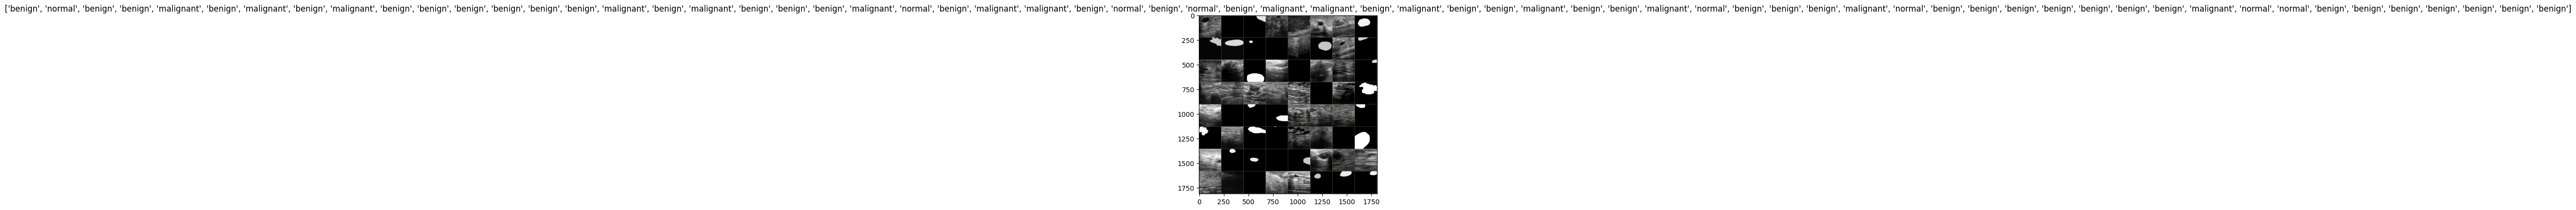

In [5]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Training']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
inputs, labels = next(iter(dataloaders['Training']))
print(type(inputs))
print(inputs.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])


In [7]:
model = models.densenet121(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.2MB/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.1)

In [9]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [10]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc: # Changed 'Test' to 'Validation'
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 3.9072 Acc: 0.3825
Validation Loss: 1.4139 Acc: 0.6509
Epoch 2/20
----------
Training Loss: 0.7681 Acc: 0.6690
Validation Loss: 0.8668 Acc: 0.6352
Epoch 3/20
----------
Training Loss: 0.5991 Acc: 0.7349
Validation Loss: 0.7574 Acc: 0.6478
Epoch 4/20
----------
Training Loss: 0.5293 Acc: 0.7754
Validation Loss: 0.6945 Acc: 0.6981
Epoch 5/20
----------
Training Loss: 0.5469 Acc: 0.7651
Validation Loss: 0.5719 Acc: 0.7358
Epoch 6/20
----------
Training Loss: 0.5136 Acc: 0.7754
Validation Loss: 0.5271 Acc: 0.7484
Epoch 7/20
----------
Training Loss: 0.4627 Acc: 0.7913
Validation Loss: 0.5916 Acc: 0.7358
Epoch 8/20
----------
Training Loss: 0.4818 Acc: 0.7881
Validation Loss: 0.5344 Acc: 0.7704
Epoch 9/20
----------
Training Loss: 0.4702 Acc: 0.7905
Validation Loss: 0.5362 Acc: 0.7673
Epoch 10/20
----------
Training Loss: 0.4510 Acc: 0.8000
Validation Loss: 0.4931 Acc: 0.7642
Epoch 11/20
----------
Training Loss: 0.4575 Acc: 0.8063
Validation Loss: 0.539